In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
from sklearn.pipeline import Pipeline
import category_encoders as ce

import sys
sys.path.insert(1, '../')

from src import preprocessing as pp
from src import analysis

# Enable module reloading
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)

plt.rcParams['figure.figsize'] = (10, 6)
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

In [2]:
from sklearn.base import TransformerMixin
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Load datasets

In [23]:
books = pd.read_csv('../data/books.csv')
reviews = pd.read_csv('../data/reviews.csv')
# intr = pd.read_csv('../data/interactions.csv')
authors = pd.read_csv('../data/authors.csv')

# Create subsets of data

In [37]:
top_n = 1000
min_review_count = 10

In [38]:
reviews.columns

Index(['user_id', 'book_id', 'review_id', 'rating', 'review_text',
       'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes',
       'n_comments'],
      dtype='object')

In [60]:
top_books = reviews[(reviews['rating'] > 0) & (~pd.isnull(reviews['review_text']))]['book_id'].value_counts().sort_values(ascending=False)

In [80]:
books['text_reviews_count'] = [top_books[i] if i in top_books.index else 0 for i in books['book_id']]

In [107]:
top_books = books[(books['language_code'] == 'eng') & 
                   (~pd.isnull(books['description']))].sort_values(by='text_reviews_count',
                                                                   ascending=False)['book_id'][:top_n]

In [112]:
top_book_reviews = reviews[reviews.book_id.isin(top_books)]

In [113]:
users = top_book_reviews.loc[:,'user_id'].value_counts().sort_values(ascending=False)

top_users = users[users >= min_review_count].index

In [114]:
len(top_users)

26340

In [115]:
top_reviews = reviews[reviews.user_id.isin(top_users) & reviews.book_id.isin(top_books)]

In [116]:
top_reviews.shape

(702030, 11)

# Train test split

In [117]:
data = top_reviews

train, test = train_test_split(data, test_size=0.01, random_state=42)

val, test = train_test_split(test, test_size=0.1, random_state=42)

In [118]:
len(train), len(val), len(test)

(695009, 6318, 703)

# Data preprocessing

In this notebook, we are going to preprocess our data, so we can use them during training.

In [226]:
import pandas as pd
import json
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import euclidean_distances

class ExportBookData(TransformerMixin):

    def __init__(self, mean_cols, books_df, authors_df, book_id_col='book_id',
                 dist_func=euclidean_distances, n_most_similar=5, mode='avg'):
        self.mean_cols = mean_cols
        self.books_df = books_df.copy()
        self.authors_df = authors_df.copy()
        self.book_id_col = book_id_col
        self.dist_func = dist_func
        self.n_most_similar = n_most_similar
        self.mode = mode
        self.users_df = pd.DataFrame()

    def fit(self, df, y=None):
        
        

        print('(fit) ExportBookData, mean_cols:', self.mean_cols,
              'book_id_col:', self.book_id_col, 'dist_func:', self.dist_func,
              'n_most_similar:', self.n_most_similar, 'mode:', self.mode)
        
        count = df[self.book_id_col].value_counts()
        self.books_df = self.books_df[self.books_df[self.book_id_col].isin(count.index)]
        self.books_df['text_reviews_count'] = count.values
        self.books_df = self.books_df.merge(df[[self.book_id_col] + self.mean_cols]
                                            .groupby(self.book_id_col).mean(), left_on='book_id',
                                 right_on='book_id')

        self.books_df["authors_names"] = [self.ExportAuthorNames(i) for i in self.books_df["authors"]]
        self.books_df["shelves_names"] = [self.ExportBookShelves(i) for i in self.books_df["popular_shelves"]]
        
        self.books_df['corpus'] = (pd.Series(self.books_df[['authors_names', 'description', 'shelves_names']].fillna('')
                .values.tolist()
                ).str.join(' '))
        
        tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, max_df=0.2, stop_words='english')
        tfidf_matrix = tf.fit_transform(self.books_df['corpus'])

        self.similarity = pd.DataFrame(data=self.dist_func(tfidf_matrix),
                                  columns=count.index, index=count.index)
        
        self.books_df = self.books_df.set_index("book_id")
        
        
        self.books_df = self.books_df.join(self.books_df.apply(self.similar, axis=1),
                                   rsuffix="_sim_" + self.mode)

        self.books_df = self.books_df.drop(['isbn', 'series', 'country_code', 'language_code',
                                  'popular_shelves', 'asin', 'is_ebook', 'average_rating',
                                  'kindle_asin', 'similar_books', 'description', 'format',
                                  'link', 'authors', 'publisher', 'num_pages', 'publication_day', 'isbn13',
                                  'publication_month', 'edition_information', 'publication_year', 'url',
                                  'image_url', 'ratings_count', 'work_id', 'title',
                                  'title_without_series', 'authors_names', 'shelves_names',
                                  'corpus'], axis=1)
        
        self.users_df = pd.DataFrame(index = df['user_id'].unique(), columns=self.books_df.index)
        
        for index, review in df.iterrows():
            self.users_df.loc[review['user_id'], review['book_id']] = review['rating']

        return self

    def transform(self, df):
        print('(transform) ExportBookData, mean_cols:', self.mean_cols,
              'book_id_col:', self.book_id_col, 'dist_func:', self.dist_func,
              'n_most_similar:', self.n_most_similar, 'mode:', self.mode)
        book_data = df.apply(lambda x: self.books_df.loc[x[self.book_id_col], :],
                                axis=1)
        user_data = pd.DataFrame(df.apply(self.get_nearest_ratings, axis=1, args=(df, 3)),
                                columns=['user_rating_avg'])
        data = book_data.join(user_data, rsuffix="_user")

        return df.join(data, rsuffix="_book_avg")

    
    def get_nearest_ratings(self, x, reviews_df, top_n=3):
        rated_books = reviews_df[reviews_df['user_id'] == x['user_id']]['book_id']
        book_indices = self.similarity.loc[x['book_id'], rated_books].nsmallest(top_n + 1)[1:].index
        return self.users_df.loc[x['user_id'], book_indices].mean()
    
    def ExportAuthorNames(self, x):
        response = ""
        for author in json.loads(x.replace('"','~').replace("'",'"').replace("~","'")):
            response += " " + self.authors_df[self.authors_df["author_id"] == int(author["author_id"])]["name"].values[0]
        return response
    
    def ExportBookShelves(self,x):
        response = ""
        for item in json.loads(x.replace("'",'"')):
            response += " " + item['name']
        return response

    def similar(self, x):
            index = x.name
            similar_books = self.similarity[index].nsmallest(self.n_most_similar + 1)[1:].index
            if self.mode == 'avg':
                return self.books_df[['text_reviews_count'] + self.mean_cols].loc[similar_books,:].mean()
            if self.mode == 'all':
                data = [r[col] for _, r in self
                        .books_df[['text_reviews_count'] + self.mean_cols].loc[similar_books, :].iterrows()
                        for col in ['text_reviews_count'] + self.mean_cols]
                cols = ['sim_' + str(i) + '_' + col for i in range(self.n_most_similar)
                        for col in ['text_reviews_count'] + self.mean_cols]
                response = pd.DataFrame(columns=cols)
                response.loc[0] = data
                return pd.Series(data, index=cols)
            raise ValueError('Invalid option for "mode" (valid options are "avg or "all')
    


In [229]:
from sklearn.metrics.pairwise import cosine_similarity

mean_cols = ['rating']

scaler = MinMaxScaler()
scale_cols = ['row_count']

drop_cols2 = ['user_id', 'book_id', 'review_id', 'review_text', 'date_added', 'date_updated', 'read_at',
             'started_at', 'n_votes', 'n_comments']

ppl = Pipeline([
    ("ExportBookData", pp.ExportBookData(mean_cols, books, authors, mode='avg', dist_func=cosine_similarity)),
])

model = ppl.fit(train[:1000])

(fit) ExportBookData, mean_cols: ['rating'] book_id_col: book_id dist_func: <function cosine_similarity at 0x7f794d660940> n_most_similar: 5 mode: avg


In [230]:
ppl.transform(train.head(1000))

(transform) ExportBookData, mean_cols: ['rating'] book_id_col: book_id dist_func: <function cosine_similarity at 0x7f794d660940> n_most_similar: 5 mode: avg


,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,text_reviews_count,rating_book_avg,text_reviews_count_sim_avg,rating_sim_avg,user_rating_avg
1365608,93ece7f66f649a9f4ad7f66ce76cdc50,12842134,90ee79c9b1ddb5969a6c6b9a45f82b87,3,3.5 stars \n I understand the story of both si...,Sun Sep 27 11:07:50 -0700 2015,Sun Oct 04 21:27:46 -0700 2015,Sun Oct 04 00:00:00 -0700 2015,Sun Sep 27 00:00:00 -0700 2015,0,0,1.0,3.000000,2.8,2.500000,NaN
199796,cd137940c501de2fbf6adae69db21b7d,20560137,4d5a9ecaef5310428f603fc3880172da,5,"** spoiler alert ** \n I loved this book, not ...",Tue Jun 02 07:42:22 -0700 2015,Sat Aug 22 09:04:01 -0700 2015,Sat Aug 22 09:04:01 -0700 2015,Wed Aug 19 00:00:00 -0700 2015,0,0,1.0,4.500000,1.6,4.400000,NaN
889228,acb8ecdba78de4a2b212d2f7da2729d4,24766,b115f6afd008cf9303f7e8b35ca974a7,4,I've read quite a few of Westerfeld's books an...,Tue Jul 01 08:09:43 -0700 2008,Thu Jul 10 15:25:30 -0700 2008,Wed Jul 02 00:00:00 -0700 2008,NaN,0,0,1.0,4.000000,2.0,3.400000,NaN
1476272,642ecf8e10ef82917c266b2812738543,7710333,66989b42d721d21a879aa12b0ba3937a,5,I have not read such a good trilogy as this on...,Wed Feb 09 22:39:10 -0800 2011,Wed Mar 02 02:32:39 -0800 2011,Wed Mar 02 00:00:00 -0800 2011,Sun Feb 27 00:00:00 -0800 2011,0,0,1.0,5.000000,1.8,4.425000,NaN
1895446,81cc4204cd1b9e5080a2e77efc4c9581,17675462,ffcd83d3a8b415b1ff2add50570781ca,3,3.5 stars,Sun Jan 26 16:14:32 -0800 2014,Fri Apr 10 14:20:33 -0700 2015,Thu Apr 09 00:00:00 -0700 2015,Sun Apr 05 00:00:00 -0700 2015,0,0,1.0,3.500000,2.4,4.100000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736611,da30e0a47f3d7b8e5a8e7ef78cf92592,17378527,8cec82b40928c830d7581052785bc9ea,4,I very much enjoyed this series and its myriad...,Wed Jun 22 07:21:15 -0700 2016,Wed Jun 22 07:21:55 -0700 2016,Wed Jun 22 07:21:55 -0700 2016,Wed Jun 22 00:00:00 -0700 2016,0,0,3.0,4.125000,2.8,3.400000,NaN
2020274,d209ec5fc6178f24c88afc15261adb59,16131489,36b592657d8e5aa20db171d67afbacc3,4,This book was painful to read! I had to take b...,Fri May 20 04:49:43 -0700 2016,Sun May 28 12:58:35 -0700 2017,Sun May 28 14:34:48 -0700 2017,Wed May 24 00:00:00 -0700 2017,9,4,3.0,3.200000,2.4,3.500000,NaN
799310,667b94d4c7e0b014bb6ab3636999e712,12425532,3b2ec3588b8d68f542cd8591bd5f0fd5,1,"Originally posted here. \n I really, really wo...",Fri Mar 02 11:01:38 -0800 2012,Mon Nov 26 10:01:33 -0800 2012,Sun May 27 00:00:00 -0700 2012,Thu May 24 00:00:00 -0700 2012,19,9,1.0,3.000000,2.6,4.200000,NaN
44197,880dc69f3de6d55a0623d61dedd49868,12971616,91446276406b83e569540e611c6fdd07,4,a little bit confusing with the fonts,Tue Jul 03 19:48:01 -0700 2012,Sat Jul 06 17:34:06 -0700 2013,Tue Sep 11 00:00:00 -0700 2012,Tue Sep 11 00:00:00 -0700 2012,0,0,2.0,4.333333,2.0,4.466667,NaN


In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk import tokenize
analyser = SentimentIntensityAnalyzer()

ModuleNotFoundError: No module named 'vaderSentiment'

In [48]:
def get_sentiment(text):
    sentences = []
    sentences_list = tokenize.sent_tokenize(text)
    sentences.extend(sentences_list)
    count = (len(sentences))
    sent = 0.0
    for sentence in sentences:
        scores = analyser.polarity_scores(sentence)
        sent += scores['compound']
    average = round((sent/count), 4) 
    if average >= 0.05 : 
        return 'positive' 
  
    elif average <= - 0.05 : 
        return 'negative'
  
    else : 
        return 'neutral'

In [49]:
reviews['review_sentiment'] = reviews['review_text'].apply(lambda x: get_sentiment(x))

In [50]:
reviews['review_sentiment']

0      neutral
1     positive
2     positive
3      neutral
4     positive
        ...   
95    positive
96    positive
97    positive
98    positive
99    positive
Name: review_sentiment, Length: 100, dtype: object

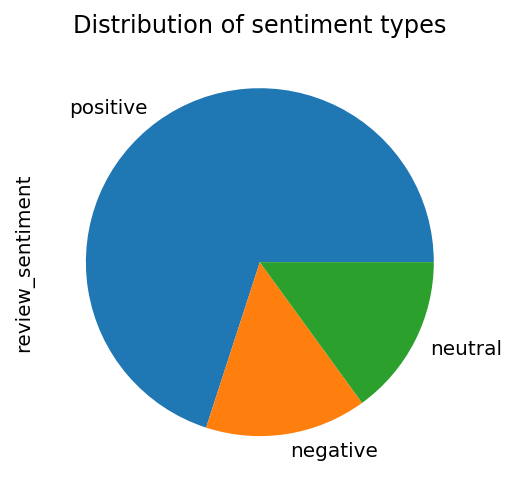

In [51]:
reviews['review_sentiment'].value_counts().plot(kind='pie', title='Distribution of sentiment types');

In [71]:
def get_most_frequent_sentiment(book_id):
    book_reviews = reviews[reviews['book_id'] == book_id]
    most_frequent_snt = book_reviews['review_sentiment'].value_counts()[:1].index.tolist()
    
    return most_frequent_snt

In [72]:
books['most_frequent_sentiment'] = books['book_id'].apply(lambda x: get_most_frequent_sentiment(x))

In [73]:
books['most_frequent_sentiment']

0        []
1        []
2        []
3        []
4        []
         ..
93393    []
93394    []
93395    []
93396    []
93397    []
Name: most_frequent_sentiment, Length: 93398, dtype: object

In [10]:
from sklearn.metrics.pairwise import linear_kernel
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

books = books[books['description'].notna()].head(3)
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(books.description)
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [7]:
tfidf_matrix

<3x340 sparse matrix of type '<class 'numpy.float64'>'
	with 345 stored elements in Compressed Sparse Row format>

In [14]:
asdf = pd.DataFrame(data=linear_kernel(tfidf_matrix, tfidf_matrix), index=books['book_id'], columns=books['book_id'])

In [15]:
asdf

book_id,12182387,20135365,21401181
book_id,,,
12182387,1.000000,0.005524,0.007715
20135365,0.005524,1.000000,0.012426
21401181,0.007715,0.012426,1.000000


In [127]:
cosine_sim

array([[1.        , 0.00790151, 0.00742666, ..., 0.01053375, 0.        ,
        0.01552667],
       [0.00790151, 1.        , 0.01454851, ..., 0.01088032, 0.        ,
        0.01477365],
       [0.00742666, 0.01454851, 1.        , ..., 0.01179341, 0.        ,
        0.01342067],
       ...,
       [0.01053375, 0.01088032, 0.01179341, ..., 1.        , 0.        ,
        0.03283576],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.01552667, 0.01477365, 0.01342067, ..., 0.03283576, 0.        ,
        1.        ]])

In [128]:
# https://www.kaggle.com/bshirude2/goodreads-content-based-book-recommendation
indices = pd.Series(books.index, index=books['book_id'])

# Get similar books based on the cosine similarity score of book descriptions
def description_recommendations(book_id):
    idx = indices[book_id]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    
    return [i[0] for i in sim_scores]

In [129]:
description_recommendations(22642971)


[10, 22, 52, 13, 37]

In [212]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english', analyzer='word').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    print(vec.get_feature_names())
    return words_freq[:n]

In [196]:
def get_top_words_per_book(book_id):
    book_reviews = reviews[reviews['book_id'] == book_id]
    book_reviews = book_reviews[book_reviews['review_text'].notna()]
    if book_reviews.empty:
        return []
    common_words = get_top_n_words(book_reviews['review_text'], 20)
    
    return common_words

In [204]:
books['top_words'] = books['book_id'].apply(lambda x: get_top_words_per_book(x))

## Merge data

In [4]:
data = pd.merge(books, reviews , on='book_id')

In [5]:
data.head(3)

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,similar_books,description,format,link,authors,publisher,num_pages,publication_day,isbn13,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series,user_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,NaN,1,['147734'],US,NaN,"[{'count': '1057', 'name': 'to-read'}, {'count...",B0056A00P4,True,4.04,B0056A00P4,"['519546', '1295074', '21407416']",This is the final tale in the bestselling auth...,NaN,https://www.goodreads.com/book/show/12182387-t...,"[{'author_id': '50873', 'role': ''}, {'author_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.goodreads.com/book/show/12182387-t...,https://s.gr-assets.com/assets/nophoto/book/11...,12182387,4,285263,"The Passion (Dark Visions, #3)","The Passion (Dark Visions, #3)",8a6085f339853bb493a8341f0d7e3bdf,fc61f4a89afd084140b9ea2090e552e2,5,Nachdem Gabriel und Lydia verschwunden sind un...,Fri Sep 09 12:32:42 -0700 2011,Wed Oct 26 11:11:47 -0700 2011,Tue Oct 25 00:00:00 -0700 2011,Sun Oct 23 00:00:00 -0700 2011,0,0
1,NaN,2,['425995'],US,NaN,"[{'count': '1010', 'name': 'to-read'}, {'count...",B006KLYIAG,True,3.80,B006KLYIAG,"['13400912', '13327517', '18107102', '15797097...",Life should be simple for Cassie.\nFor the sma...,NaN,https://www.goodreads.com/book/show/20135365-h...,"[{'author_id': '5395324', 'role': ''}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.goodreads.com/book/show/20135365-h...,https://s.gr-assets.com/assets/nophoto/book/11...,20135365,5,18450480,Hope's Daughter,Hope's Daughter,c7cafc5c262441aaa9fc8c816dcd20d5,9f5ee0e6211043932bcb46793222c2f6,4,I received this book from the author in exchan...,Wed Apr 04 11:09:28 -0700 2012,Thu Mar 20 11:44:09 -0700 2014,Thu Mar 20 11:44:09 -0700 2014,Wed Mar 19 00:00:00 -0700 2014,2,0
2,0698143760,17,['493993'],US,NaN,"[{'count': '1799', 'name': 'fantasy'}, {'count...",NaN,True,3.80,NaN,"['15728807', '17182499', '15673520', '16081758...",Wanted by no one.\nHunted by everyone.\nSixtee...,ebook,https://www.goodreads.com/book/show/21401181-h...,"[{'author_id': '7314532', 'role': ''}]",Viking Children's,416.0,4.0,9780698143760,3.0,NaN,2014.0,https://www.goodreads.com/book/show/21401181-h...,https://images.gr-assets.com/books/1394747643m...,21401181,33,24802827,"Half Bad (Half Life, #1)","Half Bad (Half Life, #1)",88d99966e16ad22b3d824758e41bdc31,d1c5a076f2433511b239dd4745d88f99,4,Dark story about a young soon to be witch boy....,Fri Mar 24 04:36:25 -0700 2017,Mon Mar 27 13:28:45 -0700 2017,Mon Mar 27 13:28:45 -0700 2017,Fri Mar 24 04:36:26 -0700 2017,0,0


## Train/Test split

In [6]:
drop_cols = ['rating']

X = data.drop(drop_cols, axis=1)

In [7]:
y = data['rating']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Create preprocessing pipeline

### books
In this section, we will try to preprocess data from book dataset.

Problems needed to be solved by preprocessing are:
- drop columns that does not contain any useful information for our task (these are also columns that contain most of the missing values)
- replace authors columns with the average rating of authors
- export shelves (by default 'favorites', 'currently-reading', 'to-read', or any other) with number of votes
- normalize and scale the numeric atributes

### Reviews

In this section, we will try to preprocess data from reviews dataset.

Problems needed to be solved by preprocessing are:
- drop columns, that does not contain any usefull information
- since we found out during analysis that longest reviews contain lots of useless data, we will set trashold for max length of review (in number of words)
- get rid of reviews that are not in english
- remove urls from reviews
- remove other special characters
- normalize and scale numeric atributes

In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

In [6]:
def print_sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(snt)))

In [11]:

print_sentiment_scores("What it it? Is it bad? :()")

What it it? Is it bad? :()-------------- {'neg': 0.391, 'neu': 0.609, 'pos': 0.0, 'compound': -0.594}


In [9]:
X_train.columns

Index(['isbn', 'text_reviews_count', 'series', 'country_code', 'language_code',
       'popular_shelves', 'asin', 'is_ebook', 'average_rating', 'kindle_asin',
       'similar_books', 'description', 'format', 'link', 'authors',
       'publisher', 'num_pages', 'publication_day', 'isbn13',
       'publication_month', 'edition_information', 'publication_year', 'url',
       'image_url', 'book_id', 'ratings_count', 'work_id', 'title',
       'title_without_series', 'user_id', 'review_id', 'review_text',
       'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes',
       'n_comments'],
      dtype='object')

In [10]:
X_train.shape

(1911920, 38)

### Test preprocessing methods

In this section we will test different method of data preprocessing and analyze the effectivity of approaches

In [11]:
def test_preprocessing(df, columns, pipelines, ppl0=None, titles=['1','2','3','4','5'], 
                       kind='box', bins=50):
    dfs = []
    if ppl0 != None:
        dfs.append(ppl0.fit(df).transform(df))
    else:
        dfs = [df]
    for ppl in pipelines:
        dfs.append(ppl.fit(df).transform(df))
        
    fig, axs = plt.subplots(len(columns),len(pipelines) + 1 ,squeeze = False, 
                            figsize = (4 * (len(pipelines) + 1), len(columns) * 4))
    
    for row,col in enumerate(columns):
        for column,df_x in enumerate(dfs):
            ax = axs[row][column] 
            ax.set_title(titles[column])
            if(kind == 'hist'):
                df_x[col].plot(kind=kind, ax=ax, legend=True, bins=bins)
            elif(kind == 'bar'):
                df_x[col].value_counts().plot(kind=kind, ax=ax, legend=True)
            else:
                df_x[col].plot(kind=kind, ax=ax, legend=True)

(fit) ZScoreNormalization
(transform) ZScoreNormalization
(fit) Scale cols: ['text_reviews_count', 'average_rating', 'num_pages', 'ratings_count']
(transform) ZScoreNormalization
(transform) Scale cols: ['text_reviews_count', 'average_rating', 'num_pages', 'ratings_count']
(fit) LogNormalization
(transform) LogNormalization
(fit) Scale cols: ['text_reviews_count', 'average_rating', 'num_pages', 'ratings_count']
(transform) LogNormalization
(transform) Scale cols: ['text_reviews_count', 'average_rating', 'num_pages', 'ratings_count']
(fit) LogNormalization


/home/vajk/Documents/FIIT/8-semester/OZNAL/oznal-project/.venv/lib/python3.7/site-packages/scipy/stats/morestats.py:1044: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


(transform) LogNormalization
(fit) Scale cols: ['text_reviews_count', 'average_rating', 'num_pages', 'ratings_count']
(transform) LogNormalization


/home/vajk/Documents/FIIT/8-semester/OZNAL/oznal-project/.venv/lib/python3.7/site-packages/scipy/stats/morestats.py:1044: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


(transform) Scale cols: ['text_reviews_count', 'average_rating', 'num_pages', 'ratings_count']


/home/vajk/Documents/FIIT/8-semester/OZNAL/oznal-project/.venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/vajk/Documents/FIIT/8-semester/OZNAL/oznal-project/.venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/vajk/Documents/FIIT/8-semester/OZNAL/oznal-project/.venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_s

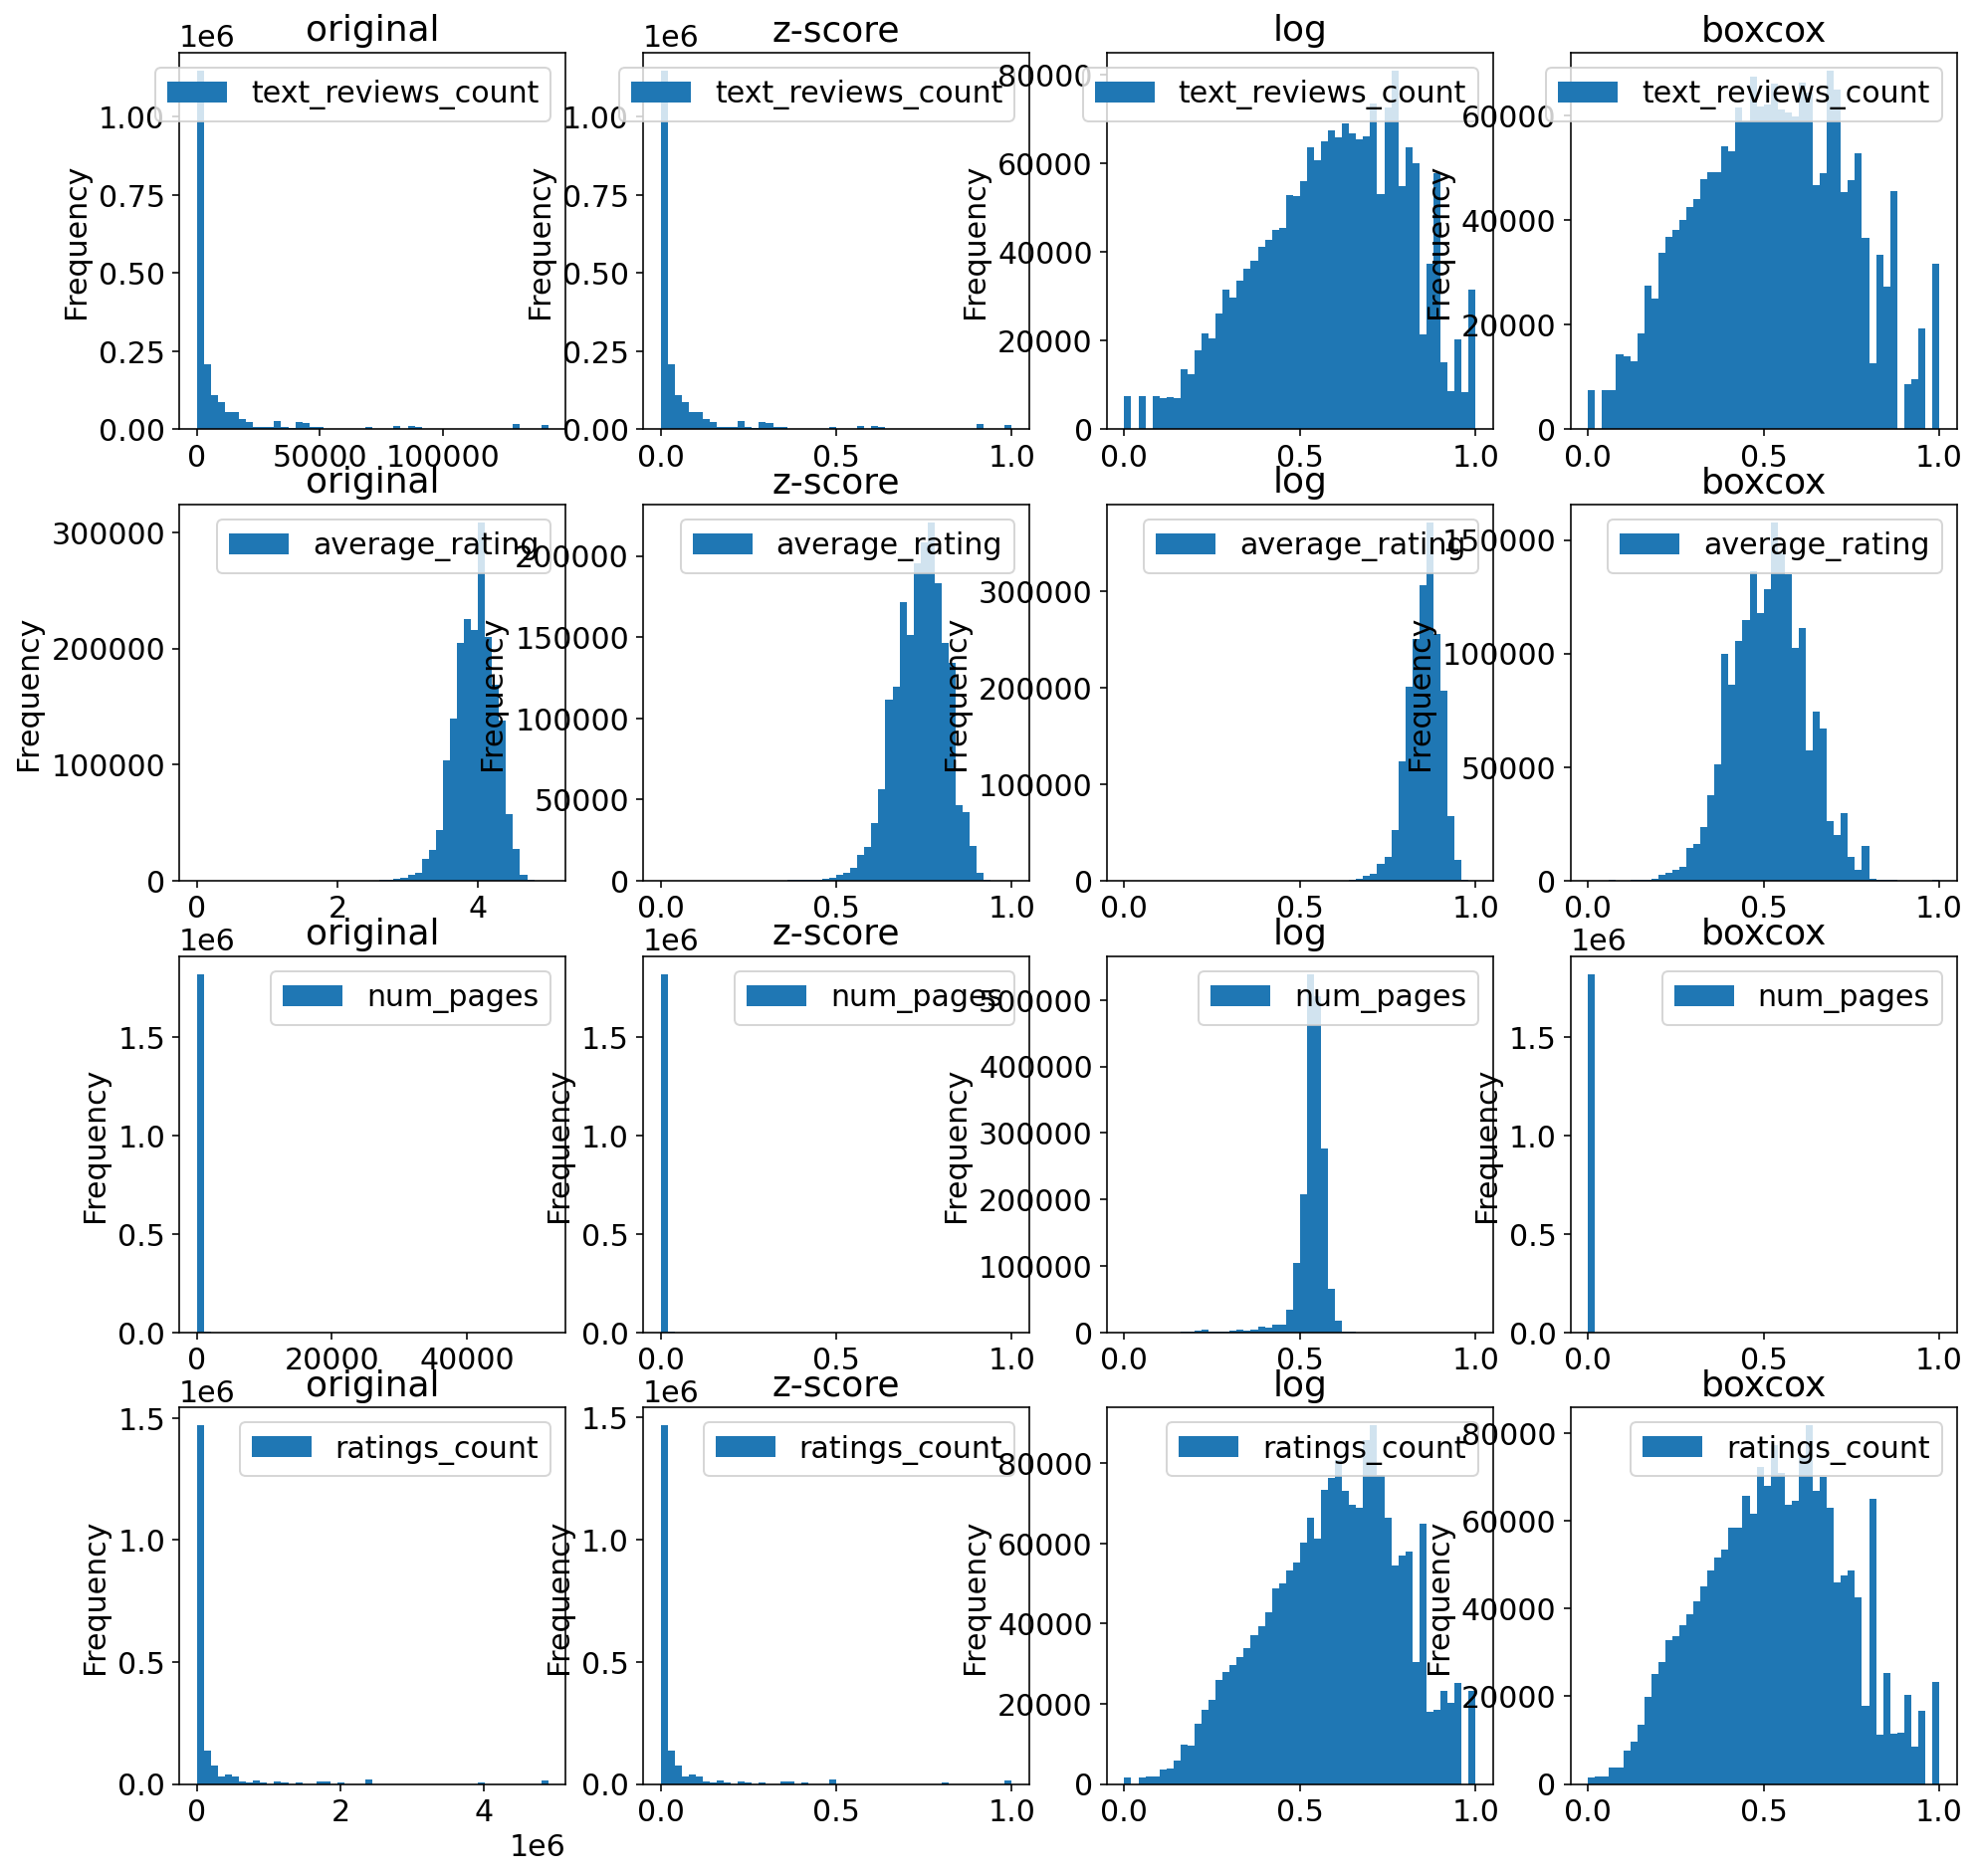

In [12]:
numeric_cols = [
                'text_reviews_count',
                'average_rating',
                'num_pages',
                'ratings_count'
               ]

scaler = MinMaxScaler(feature_range=(0,1))

def drop_zero(df, col_name):
    return [i != 0 for i in df[col_name]] 

ppl1 = Pipeline([
     ('DropZeros', pp.DropValues(numeric_cols, drop_zero)),
     ('ZScore', pp.ZScoreNormalization(numeric_cols)),
     ('Scale', pp.Scale(numeric_cols, scaler)),
])
ppl2 = Pipeline([
# #      ('Scale', pp.Scale(numeric_cols, MinMaxScaler())),
     ('DropZeros', pp.DropValues(numeric_cols, drop_zero)),
     ('Ln', pp.LogNormalization(numeric_cols)),
     ('Scale', pp.Scale(numeric_cols, scaler)),
])
ppl3 = Pipeline([
     ('DropZeros', pp.DropValues(numeric_cols, drop_zero)),
     ('Boxcox', pp.BoxCoxNormalization(numeric_cols)),
     ('Scale', pp.Scale(numeric_cols, scaler)),
])

titles = ['original', 'z-score', 'log', 'boxcox']


test_preprocessing(X_train, numeric_cols, [ppl1, ppl2, ppl3], titles=titles, kind='hist')

For skewed distributions work log and boxcox distribution pretty fine. We will use these approaches during the preprocessing

## Final pipeline

parameters setup:

In [32]:
drop_cols1 = ['isbn', 'series', 'country_code', 'language_code',
              'asin', 'kindle_asin',
              'description', 
              'format',
              'link',
              'is_ebook',
              'publisher',
              'num_pages',
              'publication_day', 'isbn13', 'publication_month',
              'edition_information',
              'publication_year', 'url', 'image_url',
              'title',
              'title_without_series',
              'date_added', 'date_updated', 'read_at', 'started_at',
              'n_votes',
              'n_comments'
             ]

replace_outliers_cols = ['text_reviews_count']

tags = ['favorites', 'currently-reading', 'to-read']

log_norm_cols = []
boxcox_norm_cols = ['text_reviews_count', 'ratings_count']

scale_cols = log_norm_cols + boxcox_norm_cols

encoder = ce.OneHotEncoder()

drop_cols2 = ['popular_shelves', 'authors', 'similar_books', 
              'work_id', 'user_id', 'book_id', 'review_id', 'review_text']

scaler = MinMaxScaler(feature_range=(0,1))

def drop_zero(df, col_name):
    return [i != 0 for i in df[col_name]] 


Final pipeline:

In [57]:
train_size = 500000

In [58]:
ppl = Pipeline([
    ('DropUnusedCols1', pp.DropColumns(drop_cols1)),
    ('SelectTopNPercentileOfBooks', pp.SelectBooksWithNPercentile('text_reviews_count', 0.75)),
#     ('DropOutliers', pp.DropOutliers(replace_outliers_cols)),
    ('DropZeros', pp.DropValues(scale_cols, drop_zero)),
#     ('Ln', pp.LogNormalization(log_norm_cols)),
    ('Boxcox', pp.BoxCoxNormalization(boxcox_norm_cols)),
    ('Scale', pp.Scale(scale_cols, scaler)),
    ('ExportAuthorsAverageRating', pp.ExportAuthorsAverageRating('authors', 'authors_average_rating', authors)),
#     ('ExportSimilarBooksAverageRating', pp.ExportSimilarBooksRating(
#         books[['book_id','average_rating']], 'similar_books', 'sim_books_average_rating')),
    ('ExtraxtPopularShelves', pp.ExportBookShelves('popular_shelves', tags)),
    ('EmptyValuesFilter', pp.EmptyValuesFilter(['review_text'])),
    ('TextPreprocessor', pp.TextPreprocessor('review_text')),
    ('ReviewLengthFilter', pp.ReviewLengthFilter('review_text', 0, 2000)),
    ('ReviewsLanguageFilter', pp.ReviewsLanguageFilter('review_text', 'en')),
    ('DropUnusedCols2', pp.DropColumns(drop_cols2)),
#     ('EncodeCategories', pp.EncodeCategories(encoder))
])

model = ppl.fit(X_train[:train_size])

(fit) Drop columns: ['isbn', 'series', 'country_code', 'language_code', 'asin', 'kindle_asin', 'description', 'format', 'link', 'is_ebook', 'publisher', 'num_pages', 'publication_day', 'isbn13', 'publication_month', 'edition_information', 'publication_year', 'url', 'image_url', 'title', 'title_without_series', 'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes', 'n_comments']
(transform) Drop columns: ['isbn', 'series', 'country_code', 'language_code', 'asin', 'kindle_asin', 'description', 'format', 'link', 'is_ebook', 'publisher', 'num_pages', 'publication_day', 'isbn13', 'publication_month', 'edition_information', 'publication_year', 'url', 'image_url', 'title', 'title_without_series', 'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes', 'n_comments']
(fit) Select books with: text_reviews_count >= 7876.0
(transform) Select books with: text_reviews_count >= 7876.0
(fit) LogNormalization
(transform) LogNormalization
(fit) Scale cols: ['text_reviews_count', 'ra

/home/vajk/Documents/FIIT/8-semester/OZNAL/oznal-project/.venv/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/vajk/Documents/FIIT/8-semester/OZNAL/oznal-project/.venv/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


(fit) ExportBookShelves, tag_col: popular_shelves, tags:['favorites', 'currently-reading', 'to-read']
(transform) ExportBookShelves, tag_col: popular_shelves, tags:['favorites', 'currently-reading', 'to-read']
(fit) Empty values filter
(transform) Empty values filter
(fit) Text preprocessing
(transform) Text preprocessing
(fit) Review length filter
(transform) Review length filter
(fit) Reviews language filter
(transform) Reviews language filter
(fit) Drop columns: ['popular_shelves', 'authors', 'similar_books', 'work_id', 'user_id', 'book_id', 'review_id', 'review_text']


In [59]:
pX_train = ppl.transform(X_train[:train_size])

(transform) Drop columns: ['isbn', 'series', 'country_code', 'language_code', 'asin', 'kindle_asin', 'description', 'format', 'link', 'is_ebook', 'publisher', 'num_pages', 'publication_day', 'isbn13', 'publication_month', 'edition_information', 'publication_year', 'url', 'image_url', 'title', 'title_without_series', 'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes', 'n_comments']
(transform) Select books with: text_reviews_count >= 7876.0
(transform) LogNormalization
(transform) Scale cols: ['text_reviews_count', 'ratings_count']
(transform) Export authors average rating


/home/vajk/Documents/FIIT/8-semester/OZNAL/oznal-project/.venv/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/vajk/Documents/FIIT/8-semester/OZNAL/oznal-project/.venv/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


(transform) ExportBookShelves, tag_col: popular_shelves, tags:['favorites', 'currently-reading', 'to-read']
(transform) Empty values filter
(transform) Text preprocessing
(transform) Review length filter
(transform) Reviews language filter
(transform) Drop columns: ['popular_shelves', 'authors', 'similar_books', 'work_id', 'user_id', 'book_id', 'review_id', 'review_text']


In [60]:
pX_train.head(3)

text_reviews_count        0
average_rating            0
ratings_count             0
authors_average_rating    0
to-read                   0
favorites                 0
currently-reading         0
dtype: int64

In [61]:
y_train.loc[pX_train.index]

1988431    3
197954     3
1390658    5
594587     5
2249627    1
          ..
229904     5
1953363    5
1764247    5
2336878    5
717299     5
Name: rating, Length: 114008, dtype: int64

In [62]:
pX_test = ppl.transform(X_test[:train_size])

(transform) Drop columns: ['isbn', 'series', 'country_code', 'language_code', 'asin', 'kindle_asin', 'description', 'format', 'link', 'is_ebook', 'publisher', 'num_pages', 'publication_day', 'isbn13', 'publication_month', 'edition_information', 'publication_year', 'url', 'image_url', 'title', 'title_without_series', 'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes', 'n_comments']
(transform) Select books with: text_reviews_count >= 7876.0
(transform) LogNormalization
(transform) Scale cols: ['text_reviews_count', 'ratings_count']
(transform) Export authors average rating


/home/vajk/Documents/FIIT/8-semester/OZNAL/oznal-project/.venv/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/vajk/Documents/FIIT/8-semester/OZNAL/oznal-project/.venv/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


(transform) ExportBookShelves, tag_col: popular_shelves, tags:['favorites', 'currently-reading', 'to-read']
(transform) Empty values filter
(transform) Text preprocessing
(transform) Review length filter
(transform) Reviews language filter
(transform) Drop columns: ['popular_shelves', 'authors', 'similar_books', 'work_id', 'user_id', 'book_id', 'review_id', 'review_text']


In [63]:
pX_test

,text_reviews_count,average_rating,ratings_count,authors_average_rating,to-read,favorites,currently-reading
1805584,0.221934,4.29,0.383735,4.21,4521,2190,1854
832821,0.610924,3.68,0.646361,3.63,77159,3675,9273
1946889,0.694326,4.15,0.613442,4.24,494863,11952,583
917716,0.272336,4.60,0.291627,4.43,4602,6508,4544
2150372,0.060080,3.80,0.177476,4.06,954,27,32
...,...,...,...,...,...,...,...
2129300,0.475464,4.34,0.674608,4.27,5947,242,7490
1138561,0.740979,4.08,0.726061,4.10,3024,16084,711
572956,0.489958,4.30,0.445353,4.24,11481,739,560
2120949,0.034484,3.93,0.154145,4.21,7944,1435,1407


# Training

### linear regression

In [81]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

In [65]:
reg = LinearRegression().fit(pX_train, y_train[pX_train.index])

In [66]:
reg.score(pX_train, y_train[pX_train.index])

0.07328514312270196

In [67]:
y_pred = reg.predict(pX_test)

In [68]:
mean_squared_error(y_test[pX_test.index], y_pred)

1.3444578330830934

In [82]:
r2_score(y_test[pX_test.index], y_pred)

0.060523533934783824

### polynomial regresion

In [76]:
polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(pX_train)

model = LinearRegression()
model.fit(x_poly, y_train[pX_train.index])
y_poly_pred = model.predict(x_poly)

In [77]:
mean_squared_error(y_train[pX_train.index],y_poly_pred)

1.3500714450670928

In [78]:
x_t = polynomial_features.transform(pX_test)

In [79]:
y_pred = model.predict(x_t)

In [80]:
mean_squared_error(y_test[pX_test.index], y_pred)

1.3606385275000137

In [83]:
r2_score(y_test[pX_test.index], y_pred)

0.060523533934783824